# Plan (from 2017_data_modeling.ipynb): 
### Inference Modeling with Cox Proportional Hazards

**Overall Goal:** Still the same – to provide statistical evidence supporting the research paper's argument about the consequences of FDA slowness by identifying factors associated with longer wait times

**Model Type: Cox Proportional Hazards (Cox PH) model** this model is designed for "time-to-event" data where some events (in this case final decisions) haven't happened yet (aka censored data)

**Key Variables:** instead of just one Y variable -> need two pieces of information for each petition:

1. **Duration:** The "Response Time (Days)" calculated (using the actual date for completed petitions and the imputed "end date" for censored ones); this is the total time the petition was observed
2. **Event:** a boolean column indicating whether the "event" (receiving a final decision) actually happened; add a boolean column "Received Final Decision" where 1 or True if final decision is 'withdrawn', 'denied', 'approved', or 'partially approved / denied', 'dismissed (moot)' else 0 or Flase if 'no decision'

**Model Output:**

* Cox PH model doesn't predict the time directly (compared to pevious)
* models the **hazard rate:** the probability of the event (getting a final decision) happening at any given time
* key outputs are hazard ratios (HR) associated with each feature (like "is_Individual", "is_Industry", etc.)

**Model Simplified**

Hazard Rate = Baseline_Hazard * exp( (coef1 * is_individual) + (coef2 * is_industry) + (coef3 * OtherFeature) + ... )

* don't usually work with the output hazard rate directly -> focus on Hazard Ratios derived from the coefficients:

    Hazard Ratio for is_Individual = exp(coef1)

    Hazard Ratio for is_Industry = exp(coef2)

    Hazard Ratio for OtherFeature = exp(coef3)

**Interpretation of Hazard Ratios (HR):** (different from OLS coefficients)

* model estimates coefficients (log-hazard ratios) -> usually exponentiate them (exp(coefficient)) to get the hazard ratio
* **HR = 1:** this factor has no effect on how quickly a decision is reached
* **HR > 1:** this factor *increases* the hazard rate ie. petitions with this factor tend to get a final decision faster (shorter wait times) compared to the baseline, holding other factors constant
* **HR < 1:** this factor *decreases* the hazard rate ie. petitions with this factor tend to get a final decision slower (longer wait times) compared to the baseline, holding other factors constant
* **magnitude:** the further the HR is from 1, the stronger the association
    * HR of 0.5: hazard is cut in half (takes roughly twice as long to get a decision) vs. HR of 2.0: hazard is doubled (takes roughly half as long)

---
### Assessing Statistical Significance (p-values for Hazard Ratios)

**Set Significance Level ($\alpha$):** choose a threshold (0.05 aka 5%) to decide if an association is statistically significant; basically a baseline for deciding when to reject the null 

**Hypotheses PER Feature:**

**Null Hypothesis:** the true hazard ratio for this specific feature is equal to 1 (i.e. this feature provides no increase/decrease in the hazard rate compared to the baseline)
**Alternative Hypothesis:** true HR for this specific feature is not equal to 1 (i.e. this feature is associated with either an increase (HR > 1) or decrease (HR < 1) in the hazard rate)
**Evaluate p-value:** for each feature, the model will give a p-value for its coefficient (log-hazard ratio).
* **p-value < $\alpha$**: reject null; conclude there is **statistically significant evidence** that this feature is associated with the response time (hazard rate), i.e. *under the null*, the observed association was unlikely to happen (aka it unlikely to happen under the null), so reject null
* **p-value >= $\alpha$**: fail to reject; there is **not enough statistical evidence** to say this feature is significantly associated with the response time at this significance level

**Note:** a small p-value indicates *confidence* that an association exists, **not** the *strength* of that association (this is the hazard ratio itself, look at previous section)

---
### Evaluating Overall Model Fit (Likelihood Ratio Test LRT)

**Purpose:** to answer "Does my model with all the chosen predictors explain the petition response times significantly better than a basic model with no predictors at all?"

**Null Model:** basic Cox model run with NO features; only estimates a baseline hazard rate and assumes none of the chosen features affect response time

**Full Model:** my Cox model including all the features I believe might influence response time

**Likelihood Scores:** software calculates a likelihood score for both models, measuring how well each model fits the observed data (response times and censoring status); higher likelihood = better fit

**Test Statistic:** LRT uses a specific statistic calculated from the difference in the log-likelihoods of the two models: `-2 * (logLik_null - logLik_full)`; larger value indicates the full model fits much better

**Hypothesis Test:**
* **Null Hypoth**: full model fits the data **no better** than the null model (ALL my features don't really have an impact).
* **Alt Hypoth**: full model fits the data **significantly better** than the null model (at least one feature significantly helps explain response times)

**p-value:** software calculates the p-value for the LRT statistic
* **p-value < $\alpha$**: reject null; my model provides a **statistically significant improvement** in explaining response times compared to the baseline
* **p-value >= $\alpha$**: fail to reject null; ALL my chosen features do not provide a statistically significant improvement over the baseline model

---
### How it Supports Research Paper:
* use the results of the LRT to show my model is valid overall
* then focus on the specific Hazard Ratios (and their p-values) for diff features that have an HR < 1 (or even greater to get more info) and are statistically significant (corresponding p-value)
* ex: if the HR for "is_Individual" is 0.4, we can say:
    * "holding other factors constant, *petitions made by individuals have only 40% of the chance of receiving a final decision* at any given time compared to the baseline group" -> indicates a strong statistical association between being an individual petitioner and experiencing significantly longer delays
    * provides the statistical foundation showing who is most affected by the FDA's slowness, making them more likely candidates for the kind of legal action seen in the AHM case

### Relating back to "accuracy" or in inference modeling term reliability and statistical significance

* I'm trying to understand *why* response times vary (this is inference)
* statistical significance: "indicates whether an observed result (each feature's HR) is likely due to a real effect or due to random chance, and is often determined by a p-value"
* LRT hypotheses testing: use the LRT to check if my model (w/ all my chosen features) explains the patterns in the response times significantly better than a model that assumes nothing matters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_years_df = pd.read_csv("/Users/anhtran/Documents/GitHub/ucb-fda-citizen-project/all_years_eda_modeling/cleaned_all_years_with_themes.csv")
all_years_df = all_years_df[all_years_df["Count of Interim"] <= 2]
all_years_df.head()

,File ID,Petition File Name,Date of Petition,Petition Source Year,Was_Withdrawn,Document Type,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,...,Responding FDA Center (of Final Decision),Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Received Final Decision,Response Time (Days),Cleaned FDA Responding Center,Responding Center Grouped,Classified_Theme
0,fda-2010-p-0648,FDA-2010-P-0648-0001_G__Pohl_Boskamp_GmbH___Co...,2010-12-16,2010,False,original petition,G. Pohl-Boskamp GmbH & Company KG \tNo law fir...,law/consulting,- 21 USC 355(b) and 355(g) – Drug approval and...,FDA's 2010 Draft Bioequivalence Recomm...,...,Center for Drug Evaluation and Research (CDER),"Section 505(j) of the Federal Food, Drug, and ...",The FDA states it has not resolved the issues ...,Scientific Basis: FDA carefully reviewed the p...,partially approved / denied,True,1050.0,CDER,CDER,Regulatory Process & Guidance
1,fda-2010-p-0642,FDA-2010-P-0642-0005_Teva_Pharmaceutical_Indus...,2011-02-11,2010,False,original petition,Teva Pharmaceutical Industries Ltd. and Teva N...,industry/corporation,- 21 C.F.R. § 10.30 – Citizen petition process...,FDA’s approach to approving Abbreviated New Dr...,...,Center for Drug Evaluation and Research (CDER)...,Section 505(q) of the FDCA (21 U.S.C. § 355)\n...,NaN,FDA emphasized its broad discretion under the ...,denied,True,117.0,CDER,CDER,Regulatory Process & Guidance
2,fda-2010-p-0011,FDA-2010-P-0011-0001_Bright_Future_Pharmaceuti...,2010-01-04,2010,False,original petition,Bright Future Pharmaceutical Lab. Ltd.,advocacy/academic,Section 505(j)(2)(C) of the FDCA; 21 CFR 25.300,Request to designate Panadol® as RLD or advise...,...,NaN,NaN,NaN,NaN,no decision,False,5763.0,pending,pending,Market Availability & Formulation
3,fda-2010-p-0012,FDA-2010-P-0012-0001_Patrick_Foster___Citizen_...,2009-12-21,2010,False,original petition,Patrick Foster,individual,Section 505(j)(2)(C) of the FDCA; 21 CFR §§ 10...,Petition to allow ANDA for higher concentratio...,...,Division of Dockets Management,Not Mentioned,NaN,Petition was withdrawn by Alaunus Pharmaceutic...,withdrawn,True,321.0,DMS,Other/Specialty Center,Market Availability & Formulation
4,fda-2010-p-0015,FDA-2010-P-0015-0001_Lachman_Consultant_Servic...,2010-01-05,2010,False,original petition,"Lachman Consultant Services, Inc.",law/consulting,Section 505(j)(2)(C) of the FDCA; 21 CFR 10.30,ANDA request for strength change of Zolpidem T...,...,Center for Drug Evaluation and Research (CDER),21 C.F.R. § 10.30; Section 505(j)(2)(C) of the...,NaN,The proposed 7.5 mg strength is not supported ...,denied,True,269.0,CDER,CDER,Market Availability & Formulation


/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_25286/1494376874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = all_years_df, y = "Submitter Type", order = order, palette = "viridis")


Text(0, 0.5, 'Submitter Type')

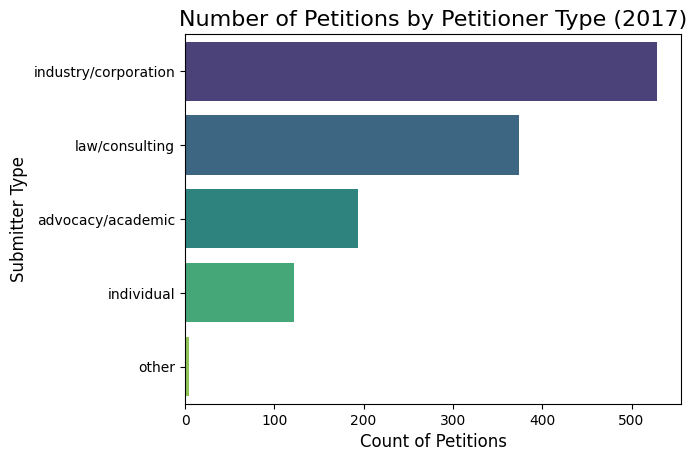

In [3]:
# count of petitions by submitter type 
order = all_years_df["Submitter Type"].value_counts().index
sns.countplot(data = all_years_df, y = "Submitter Type", order = order, palette = "viridis")
plt.title('Number of Petitions by Petitioner Type (2017)', fontsize=16)
plt.xlabel('Count of Petitions', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

#### Quick Analysis of Bar Plot:
* most petitions are filled out by either industry/corps or law/consulting
* avd/aca & individuals tied for having the least (not considering other)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_25286/4253548128.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = all_years_df, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")


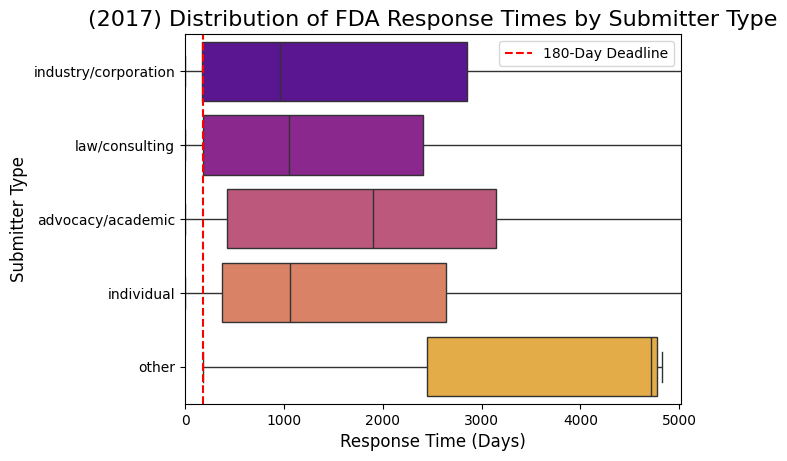

In [4]:
# response time by submitter type 
sns.boxplot(data = all_years_df, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")
plt.title("(2017) Distribution of FDA Response Times by Submitter Type", fontsize=16)
plt.xlabel('Response Time (Days)', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

# Gemini code below
# Limit x-axis to the 95th percentile for better readability, ignoring negative times
plt.xlim(0, all_years_df[all_years_df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x = 180, color = 'r', linestyle = '--', label = '180-Day Deadline')
plt.legend()

#### Quick Analysis of Box Plot:
* median line splits the data exactly 50/50
  * no submitter category's median line is near the 180-day deadline
  * "other" have the most delayed response time from the fda bc of median line is the furthest, followed by avd/acad 
  * indus/corp & law/consult & indiv about the same in terms median line and box
* box itself is middle 50% (boxplot is split into 25/25/25/25 -> box is middle 50)
  * all submitter categories have similar spread/box size; data is NOT around the 1800 deadline which is BAD bc fda usually take much longer 
* dots are outliers, end of whiskers show minimum and maximum

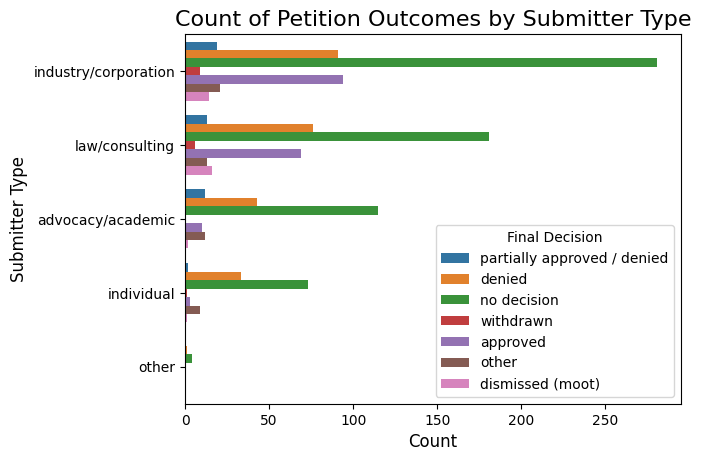

In [5]:
# stacked bar plot of count of petition final decision by submitter type
sns.countplot(data = all_years_df, y = "Submitter Type", hue = "Cleaned Final Decision", order = order)

plt.title("Count of Petition Outcomes by Submitter Type", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Submitter Type", fontsize=12)
plt.legend(title = "Final Decision")

Text(0.5, 1.0, 'Distribution of Response Times')

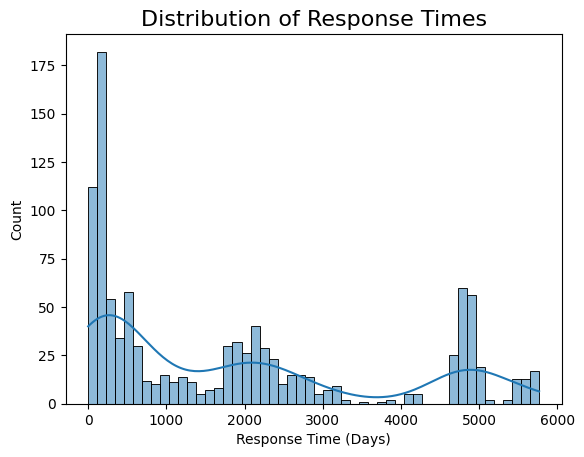

In [6]:
d = all_years_df[all_years_df["Response Time (Days)"] > 0]
sns.histplot(d["Response Time (Days)"].dropna(), kde = True, bins = 50)
plt.title("Distribution of Response Times", fontsize=16)

long tail stretching to the right:
* a decent amount of petitions getting super delayed response time
* supports paper because AHM was able to push forward because of long wait times

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_25286/2712651957.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")


Text(0.5, 1.0, 'Response Time vs. Number of Interim Responses')

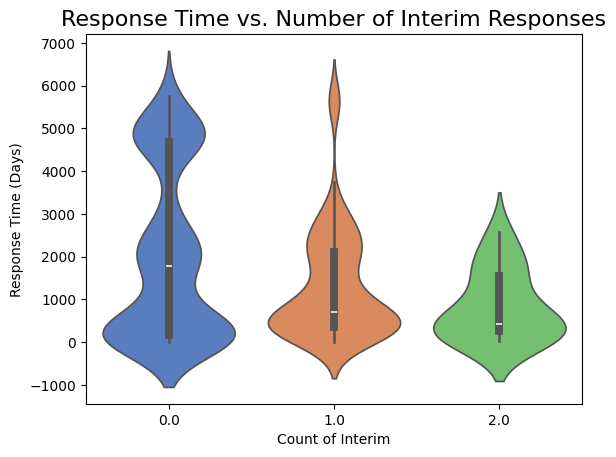

In [7]:
sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")
plt.title("Response Time vs. Number of Interim Responses", fontsize=16)

#### Quick Analysis of Violin Plot:
* box for the data that had 1 interim shows that most of the data get less variability in response times than those with no interim bc of the spread (supports YES interim = shorter response time)
* median line for those with 0 interim versus 1 interim shows that 0 interim get a slower median response time compared to 1 interim (supports YES interim = shorter response time)
* once again the problem is the long tail that goes nearly all the way to 7000 for both interims

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_25286/3515680735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_years_df, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", palette = "deep", fliersize=0) # fliersize=0 hides outliers; stripplot shows them


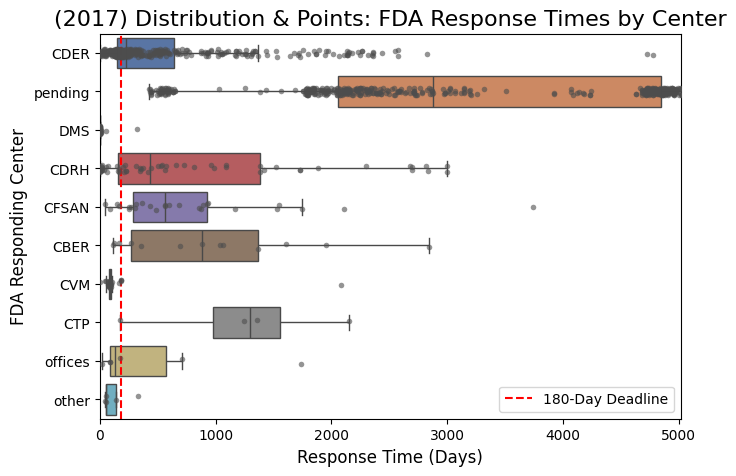

In [8]:
plt.figure(figsize=(7.5, 5))

sns.boxplot(data=all_years_df, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", palette = "deep", fliersize=0) # fliersize=0 hides outliers; stripplot shows them

# overlay the datapoints
sns.stripplot(data=all_years_df, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", color=".3", size=4, alpha=0.6) 

plt.title("(2017) Distribution & Points: FDA Response Times by Center", fontsize=16)
plt.xlabel("Response Time (Days)", fontsize=12)
plt.ylabel("FDA Responding Center", fontsize=12)

# Gemini Code for drawing 180 day line
plt.xlim(0, all_years_df[all_years_df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x=180, color = 'r', linestyle = '--', label='180-Day Deadline')
plt.legend()
plt.show()

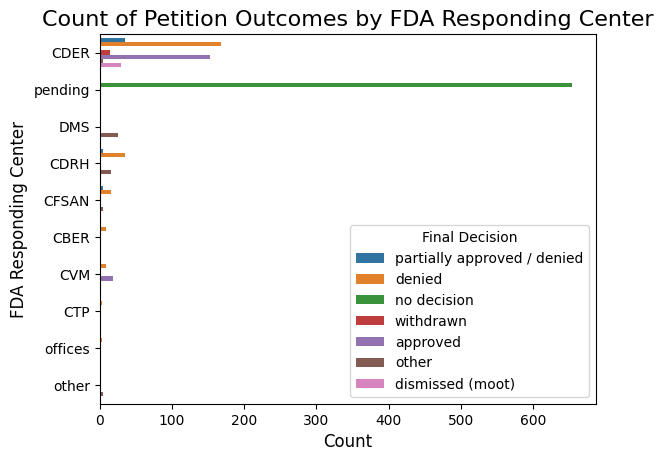

In [9]:
sns.countplot(data = all_years_df, y = "Cleaned FDA Responding Center", hue = "Cleaned Final Decision")

plt.title("Count of Petition Outcomes by FDA Responding Center", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("FDA Responding Center", fontsize=12)
plt.legend(title = "Final Decision")

In [10]:
display(all_years_df["Classified_Theme"].unique())

# merge 'Unassigned / No Valid Text' and 'Unassigned' into single 'Unassigned' category
all_years_df['Classified Theme Grouped'] = np.where(
    all_years_df['Classified_Theme'].isin(['Unassigned / No Valid Text', 'Unassigned']),
    'Unassigned',
    all_years_df['Classified_Theme']
)

display(all_years_df["Classified Theme Grouped"].value_counts())

array(['Regulatory Process & Guidance',
       'Market Availability & Formulation',
       'Product Quality, Safety & Recalls', 'Unassigned / No Valid Text',
       'Unassigned'], dtype=object)

Classified Theme Grouped
Regulatory Process & Guidance        624
Market Availability & Formulation    262
Product Quality, Safety & Recalls    261
Unassigned                            77
Name: count, dtype: int64

## Cox PH Model
**features in model:**
* submitter type
* count of interim
* responding fda center
* document type (og or recon, might be more useful when adding the datasets of diff years)
* year

In [11]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import OneHotEncoder

In [12]:
all_years_df.columns

Index(['File ID', 'Petition File Name', 'Date of Petition',
       'Petition Source Year', 'Was_Withdrawn', 'Document Type', 'Submitter',
       'Submitter Type', 'Petition Cited Statutes or Regulations',
       'FDA Action Commented On', 'Requested Action',
       'Justification for Request', 'Interim Response Date', 'Final Decision',
       'Last Response Date', 'Count of Interim',
       'Responding FDA Center (of Final Decision)',
       'Responses Cited Statutes or Regulations',
       'Justification for Interim Response',
       'Justification for Final Response', 'Cleaned Final Decision',
       'Received Final Decision', 'Response Time (Days)',
       'Cleaned FDA Responding Center', 'Responding Center Grouped',
       'Classified_Theme', 'Classified Theme Grouped'],
      dtype='object')

In [13]:
model_df = all_years_df[["Response Time (Days)", "Received Final Decision", "Submitter Type", "Count of Interim", 
                         "Responding Center Grouped", "Document Type", "Petition Source Year", "Classified Theme Grouped"]]

def ohe(data, col, col_drop):
    # one-hot-encodes categorical features
    oh_enc = OneHotEncoder(drop = [col_drop], sparse_output = False)
    encoded_features = oh_enc.fit_transform(data[[col]])

    # df contains ONLY the new OHE columns
    encoded_cols_df = pd.DataFrame(encoded_features,
                                   columns=oh_enc.get_feature_names_out([col]),
                                   index=data.index)

    data_wo_og_col = data.drop(columns=[col])
    ohe_data = data_wo_og_col.join(encoded_cols_df)

    return ohe_data

data_encoded = model_df.dropna()
data_encoded = ohe(data_encoded, "Submitter Type", col_drop="advocacy/academic")
data_encoded = ohe(data_encoded, "Responding Center Grouped", col_drop="CDER")
data_encoded = ohe(data_encoded, "Document Type", col_drop="original petition")
data_encoded = ohe(data_encoded, "Classified Theme Grouped", col_drop="Unassigned")

In [14]:
print("Debugging Checks Before Fitting (model is sensitive)")

# check NaNs in the final df
print("Checking for NaNs:")
nan_counts_final = data_encoded.isnull().sum()
print(nan_counts_final[nan_counts_final > 0])
if nan_counts_final.sum() > 0:
    print("Error: NaNs still present!")

# check for nfinite values
print("\nChecking for Infinite values:")
inf_check = data_encoded.isin([np.inf, -np.inf]).sum()
print(inf_check[inf_check > 0])
if inf_check.sum() > 0:
    print("Error: Infinite values detected!")

# 3. check data types 
print("\nChecking data types again:")
print(data_encoded.info())

# 4. examine duration and event columns specifically
print("\nSummary statistics for Duration and Event:")
print(data_encoded[["Response Time (Days)", "Received Final Decision"]].describe())

print("\nValue counts for Event column:")
print(data_encoded["Received Final Decision"].value_counts())

print("\n--- Checking for Zero-Variance Features ---")
# Calculate the variance for each column
variances = data_encoded.var()

# Find columns with zero or near-zero variance
low_variance_cols = variances[variances < 1e-5] # 1e-5 is a very small number

if not low_variance_cols.empty:
    print("Found columns with zero or very low variance:")
    print(low_variance_cols)
    
    # Drop these problematic columns
    cols_to_drop = low_variance_cols.index.tolist()
    print(f"\nDropping these columns: {cols_to_drop}")
    data_encoded = data_encoded.drop(columns=cols_to_drop)
    
else:
    print("No zero-variance columns found. Problem might be elsewhere.")

Debugging Checks Before Fitting (model is sensitive)
Checking for NaNs:
Series([], dtype: int64)

Checking for Infinite values:
Series([], dtype: int64)

Checking data types again:
<class 'pandas.core.frame.DataFrame'>
Index: 1042 entries, 0 to 1248
Data columns (total 15 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Response Time (Days)                                        1042 non-null   float64
 1   Received Final Decision                                     1042 non-null   bool   
 2   Count of Interim                                            1042 non-null   float64
 3   Petition Source Year                                        1042 non-null   int64  
 4   Submitter Type_individual                                   1042 non-null   float64
 5   Submitter Type_industry/corporation                         1042 non-null   float64
 6   

In [15]:
# STANDARD Cox Model (no regularization) for features EXCLUDING vectorized words
# UNCOMMENT ALL TO USE STANDARD COX MODEL

# verify the required columns exist
required_cols = ["Response Time (Days)", "Received Final Decision"]
if not all(col in data_encoded.columns for col in required_cols):
    print(f"Error: Missing required columns. Ensure 'Response Time (Days)' and 'Received Final Decision' are in the DataFrame.")
    print("Available columns:", data_encoded.columns)
else:
    # create the cox model object 
    # creates an empty model ready to be trained
    cph = CoxPHFitter()
    print("CoxPHFitter object created.")

    # fit model to my data
    try:
        cph.fit(data_encoded,
                duration_col = "Response Time (Days)",
                event_col = "Received Final Decision")

        print("\nModel fitting complete!")

        # view results 
        # print_summary() method displays the main results table
        print("\n--- Cox Proportional Hazards Model Summary ---")
        cph.print_summary(decimals=3) # decimals=3 controls rounding

    except Exception as e:
        print(f"\nAn error occurred during model fitting: {e}")
        print("This might be due to remaining NaN values, non-numeric data, or issues with the duration/event columns.")
        print("Double-check the output of Step 2 (data preparation).")

CoxPHFitter object created.

Model fitting complete!

--- Cox Proportional Hazards Model Summary ---


/Users/anhtran/Library/Python/3.9/lib/python/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Responding Center Grouped_CDRH have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Received Final Decision'].astype(bool)
>>> print(df.loc[events, 'Responding Center Grouped_CDRH'].var())
>>> print(df.loc[~events, 'Responding Center Grouped_CDRH'].var())

A very low variance means that the column Responding Center Grouped_CDRH completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/anhtran/Library/Python/3.9/lib/python/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(d

<lifelines.CoxPHFitter: fitted with 1042 total observations, 477 right-censored observations>
             duration col = 'Response Time (Days)'
                event col = 'Received Final Decision'
      baseline estimation = breslow
   number of observations = 1042
number of events observed = 565
   partial log-likelihood = -2948.530
         time fit was run = 2025-11-26 11:14:13 UTC

---
                                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                     
Count of Interim                                            -0.730     0.482     0.092          -0.910          -0.550               0.403               0.577
Petition Source Year                                         0.050     1.051     0.013           0.025           0.074               1.026               1.077
Submitter Type_individual                                    0.018     1.019     0.187          -0.348           0.385               0.706               1.470
Submitter Type_industry/corporation                          0.351     1.421     0.142           0.073           0.630               1.076               1.877
Submitter Type_law/consulting                                0.018     1.018     0.147          -0.271           0.306               0.762               1.359
Submitter Type_other                                        -0.136     0.873     1.013          -2.122           1.851               0.120               6.363
Responding Center Grouped_CDRH                              -0.169     0.844     0.176          -0.513           0.175               0.598               1.191
Responding Center Grouped_Other/Specialty Center             0.504     1.655     0.129           0.251           0.757               1.285               2.131
Responding Center Grouped_pending                          -21.795     0.000  1066.034       -2111.183        2067.593               0.000                 inf
Document Type_reconsideration                               -0.237     0.789     0.508          -1.233           0.759               0.291               2.136
Classified Theme Grouped_Market Availability & Formulation  -0.541     0.582     0.203          -0.939          -0.143               0.391               0.866
Classified Theme Grouped_Product Quality, Safety & Recalls   0.616     1.851     0.197           0.230           1.001               1.259               2.721
Classified Theme Grouped_Regulatory Process & Guidance       0.132     1.141     0.186          -0.232           0.496               0.793               1.642

                                                            cmp to      z       p  -log2(p)
covariate                                                                                  
Count of Interim                                             0.000 -7.959 <0.0005    49.036
Petition Source Year                                         0.000  3.979 <0.0005    13.821
Submitter Type_individual                                    0.000  0.099   0.921     0.118
Submitter Type_industry/corporation                          0.000  2.473   0.013     6.222
Submitter Type_law/consulting                                0.000  0.119   0.905     0.143
Submitter Type_other                                         0.000 -0.134   0.893     0.163
Responding Center Grouped_CDRH                               0.000 -0.965   0.335     1.580
Responding Center Grouped_Other/Specialty Center             0.000  3.904 <0.0005    13.366
Responding Center Grouped_pending                            0.000 -0.020   0.984     0.024
Document Type_reconsideration                                0.000 -0.467   0.641     0.642
Classified Theme Grouped_Market Availability & Formulation   0.000 -2.666   0.008     7.026
Classified Theme Groupe

In [16]:
summary_df = cph.summary

alpha = 0.05
significant_features = summary_df[summary_df['p'] < alpha]

print(f"\n--- Statistically Significant Feature(s) (p < {alpha}) ---")
display(significant_features)


--- Statistically Significant Feature(s) (p < 0.05) ---


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Count of Interim,-0.730029,0.481895,0.091723,-0.909802,-0.550256,0.402604,0.576802,0.0,-7.959086,1.733144e-15,49.035530
Petition Source Year,0.049772,1.051031,0.012508,0.025257,0.074287,1.025579,1.077115,0.0,3.979304,6.911719e-05,13.820596
Submitter Type_industry/corporation,0.351273,1.420876,0.142034,0.072892,0.629655,1.075614,1.876962,0.0,2.473165,1.339224e-02,6.222459
Responding Center Grouped_Other/Specialty Center,0.503732,1.654885,0.129038,0.250822,0.756641,1.285082,2.131106,0.0,3.903756,9.471120e-05,13.366105
Classified Theme Grouped_Market Availability & Formulation,-0.541139,0.582085,0.202966,-0.938945,-0.143332,0.391040,0.866466,0.0,-2.666153,7.672480e-03,7.026091
"Classified Theme Grouped_Product Quality, Safety & Recalls",0.615660,1.850878,0.196621,0.230290,1.001031,1.258965,2.721085,0.0,3.131199,1.740940e-03,9.165918


### **RECALL:**
**Interpretation of Hazard Ratios (HR):** (different from OLS coefficients)

* model estimates coefficients (log-hazard ratios) -> usually exponentiate them (exp(coefficient)) to get the hazard ratio
* **HR = 1:** this factor has no effect on how quickly a decision is reached
* **HR > 1:** this factor *increases* the hazard rate ie. petitions with this factor tend to get a final decision faster (shorter wait times) compared to the baseline, holding other factors constant
* **HR < 1:** this factor *decreases* the hazard rate ie. petitions with this factor tend to get a final decision slower (longer wait times) compared to the baseline, holding other factors constant
* **magnitude:** the further the HR is from 1, the stronger the association
    * HR of 0.5: hazard is cut in half (takes roughly twice as long to get a decision) vs. HR of 2.0: hazard is doubled (takes roughly half as long)

---
### Assessing Statistical Significance (p-values for Hazard Ratios)

**Set Significance Level ($\alpha$):** choose a threshold (0.05 aka 5%) to decide if an association is statistically significant; basically a baseline for deciding when to reject the null 

**Hypotheses PER Feature:**

**Null Hypothesis:** the true hazard ratio for this specific feature is equal to 1 (i.e. this feature provides no increase/decrease in the hazard rate compared to the baseline)

**Alternative Hypothesis:** true HR for this specific feature is not equal to 1 (i.e. this feature is associated with either an increase (HR > 1) or decrease (HR < 1) in the hazard rate)

**Evaluate p-value:** for each feature, the model will give a p-value for its coefficient (log-hazard ratio).

* **p-value < $\alpha$**: reject null; conclude there is **statistically significant evidence** that this feature is associated with the response time (hazard rate), i.e. *under the null*, the observed association was unlikely to happen (aka it unlikely to happen under the null), so reject null
* **p-value >= $\alpha$**: fail to reject; there is **not enough statistical evidence** to say this feature is significantly associated with the response time at this significance level

**Note:** a small p-value indicates *confidence* that an association exists, **not** the *strength* of that association (this is the hazard ratio itself, look at previous section)

---

### Intepretation of Results from Model
#### C-index

Concordance Index (C-index): prediction-based metric for inference modeling; answers "how good is my model at distinguishing which petition waits longer?"

why prediction metric for inference?
* if my model has no predictive power, its inferences are worthless
* C-index validates that the model actually has learned real patterns from the given data, which makes you confident in its inferences

measures the model's **discriminatory power**:

ex: let's pick two petitions at random from the dataset (petition A & petition B) ---> already know: petition A received its final decision (the "event") sooner than petition B
1. asks already fitted Cox model to predict which one would finish first.
2. C-index: the percentage of time the model's prediction is correct
    * C-index = 0.5: model is just guessing (50/50); no discriminatory power
    * C-index = 0.7: 70% of the time, the model correctly identifies which of the two petitions will get a decision first (aim for 0.7 or higher)
    * C-index = 1.0: perfect

**my model's C-index: 0.872**
* model is much better than random chance (50/50) at identifying which petitions will face delays
* very high for this kind of real-world data -> confirms that my model has learned extremely powerful and reliable patterns

---
#### Overall Model Fit

-log2(p) of ll-ratio test: inf
* actual p-value is practically 0
* the model as a whole (with all chosen predictors) fits the data significantly better than a model with no predictors
---
#### Statistically Significant Features (p-val > 0.05)
**Count of Interim:**

HR = 0.731227 (< 1)

Interpretation: 
* receiving an interim response is associated with a slower rate of getting a final decision (HR < 1)
* result is statistically significant at the 0.05 level; enough evidence in this model to confidently say interim responses slow things down after accounting for other factors

**Petition Source Year:**

HR = 1.050276 (> 1)

Interpretation: 
* year of petition filed is associated with a faster rate of getting a final decision

**Submitter Type_industry/corporation:**

HR = 1.551604 (> 1)

Interpretation: 
* compared to the baseline group ("academic/adv bc it's first alphabetically and used drop_first=True), industry/corp petitioners have a hazard rate about 1.55 times higher, meaning they tend to get final decisions significantly faster than academic/adv
    * i.e: academic/adv petitioners get their decisions significantly slower than indust/corp petitioners

**Responding Center Grouped_Other/Specialty Center:**

HR = 1.596599 (> 1)

Interpretation: 
* compared to the baseline group (CDER resp. center), petitions that get other/specialty center appear to get decisions 1.6 times faster than CDER
* this category includes centers such as ['CBER', 'CFSAN', 'CVM', 'DMS', 'offices', 'other', 'CTP']

**Classified Theme Grouped_Market Availability & Formulation:**

HR = 0.582085 (< 1)

Interpretation: 
* compared to the baseline group ("Unassigned" theme aka the average unclassifiable/ noise category), petitions that get other/specialty center appear to get decisions 0.6 times slower than the average unclassifiable/ noise category

**Classified Theme Grouped_Product Quality, Safety & Recalls**

HR = 1.850878 (> 1)

Interpretation: 
* compared to the baseline group ("Unassigned" theme aka the average unclassifiable/ noise category), petitions that get classified as "Product Quality, Safety & Recalls" appear to get decisions about 2 times faster than the average unclassifiable/ noise category

**NOTE: NOT stat signif means...**
* model did NOT find enough statistical evidence to say they are any different from the academic/adv group or CBER
* cannot conclude these non-signif features slow things down -> can only conclude lack sufficient evidence to prove they have an effect
* i.e: statistically, these not stat signif features are all in the same "slower" boat compared to indust/corp or CBER


--- Features Failing Proportional Hazards Test (p < 0.01) ---
                                                    test_statistic  \
Responding Center Grouped_Other/Specialty Center         55.181037   
Count of Interim                                         48.168075   
Responding Center Grouped_CDRH                           12.265246   
Submitter Type_industry/corporation                      10.013006   
Classified Theme Grouped_Product Quality, Safet...        9.677484   
Classified Theme Grouped_Regulatory Process & G...        8.909838   
Document Type_reconsideration                             5.882666   

                                                               p   -log2(p)  
Responding Center Grouped_Other/Specialty Center    1.099241e-13  43.048557  
Count of Interim                                    3.912061e-12  37.895208  
Responding Center Grouped_CDRH                      4.614723e-04  11.081468  
Submitter Type_industry/corporation                 1.554386e-03 

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1042 total observations, 477 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                 test_statistic      p  -log2(p)
Classified Theme Grouped_Market Availability & Formulation km              0.72   0.40      1.33
                                                           rank            0.60   0.44      1.20
Classified Theme Grouped_Product Quality, Safety & Recalls km              9.68 <0.005      9.06
                                                           rank            9.68 <0.005      9.07
Classified Theme Grouped_Regulatory Process & Guidance     km              9.27 <0.005      8.75
                                                           rank            8.91 <0.005      8.46
Count of Interim                                           km             47.31 <0.005     37.27
                                                           rank           48.17 <0.005     37.90
Document Type_reconsideration                              km              5.62   0.02      5.82
                                                           rank            5.88   0.02      6.03
Petition Source Year                                       km              3.04   0.08      3.62
                                                           rank            2.81   0.09      3.41
Responding Center Grouped_CDRH                             km             12.03 <0.005     10.90
                                                           rank           12.27 <0.005     11.08
Responding Center Grouped_Other/Specialty Center           km             53.81 <0.005     42.04
                                                           rank           55.18 <0.005     43.05
Responding Center Grouped_pending                          km              0.00   1.00      0.00
                                                           rank            0.00   1.00      0.00
Submitter Type_individual                                  km              0.14   0.71      0.49
                                                           rank            0.16   0.69      0.53
Submitter Type_industry/corporation                        km             10.02 <0.005      9.34
                                                           rank           10.01 <0.005      9.33
Submitter Type_law/consulting                              km              1.12   0.29      1.78
                                                           rank            1.19   0.28      1.86
Submitter Type_other                                       km              1.53   0.22      2.21
                                                           rank            1.60   0.21      2.28



1. Variable 'Count of Interim' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['Count of Interim', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Submitter Type_industry/corporation' failed the non-proportional test: p-value is 0.0015.

   Advice: with so few unique values (only 2), you can include `strata=['Submitter
Type_industry/corporation', ...]` in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'Responding Center Grouped_Other/Specialty Center' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Responding Center
Grouped_Other/Specialty Center', ...]` in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


4.

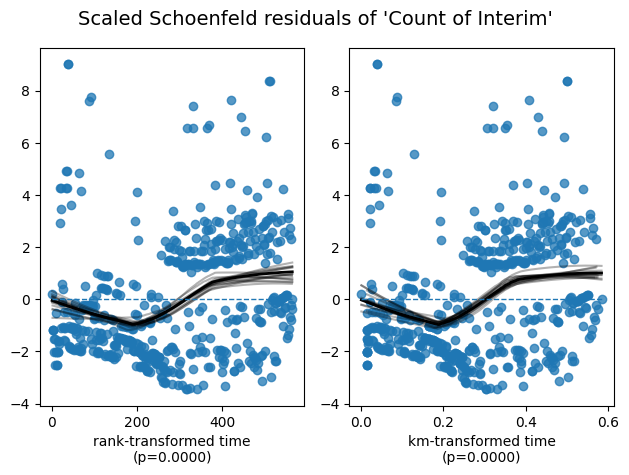

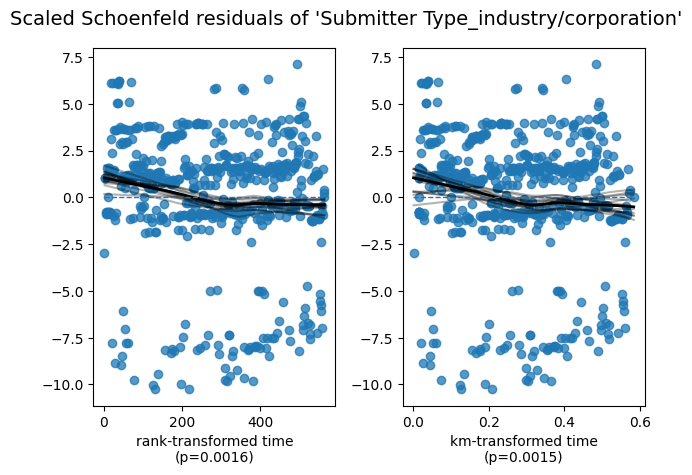

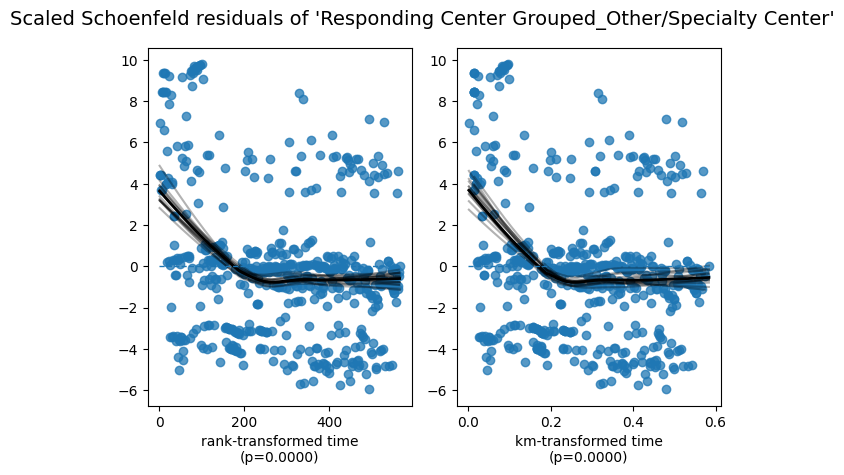

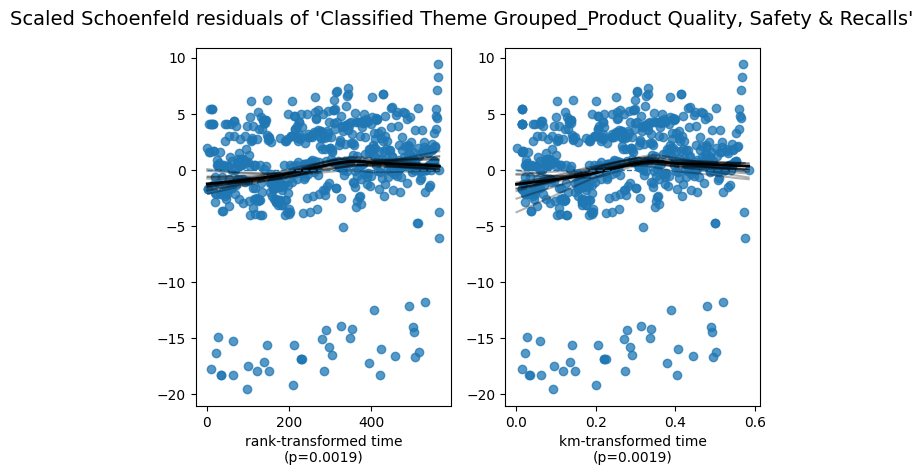

In [17]:
from lifelines.statistics import proportional_hazard_test
ph_test_threshold = 0.01

summary_df = cph.summary

alpha = 0.05
significant_features = summary_df[summary_df['p'] < alpha]

# list of statistically significant features
significant = significant_features.index.tolist()

# run per-covariate PH test
ph_test = proportional_hazard_test(cph, data_encoded, time_transform='rank')
summary = ph_test.summary   # DataFrame with p-values

# Access the summary DataFrame and filter for p-values less than alpha
# Sort the results by p-value to see the most severe violations first
failing_features_summary = summary[summary['p'] < alpha].sort_values(by='p')

print("--- Features Failing Proportional Hazards Test (p < 0.01) ---")
print(failing_features_summary)

# list of feature names that fail the test
failing = summary[summary['p'] < ph_test_threshold].index.tolist()

# list of features that failed the PH test and are statistically significant
fail_ph_stat_signif = pd.Series(failing)[pd.Series(failing).isin(pd.Series(significant))].tolist()

print("\n", f"--- Schoenfeld Plots for Failed Features ---")
if fail_ph_stat_signif:
    # show plots only for failing features
    cph.check_assumptions(data_encoded, show_plots=True, p_value_threshold=ph_test_threshold, columns=fail_ph_stat_signif)
else:
    print("No features failed the proportional hazards test.")


In [18]:
display(fail_ph_stat_signif)


['Classified Theme Grouped_Product Quality, Safety & Recalls',
 'Count of Interim',
 'Responding Center Grouped_Other/Specialty Center',
 'Submitter Type_industry/corporation']

### How to analyze plots above:
#### Overall Analysis
1. look at the main model summary table (ABOVE) and identify the features that are stat. signif.
    * exp(coef) (hazard ratio) and its p-value
    * purpose: tells us the feature's AVERAGE effect across all time points (e.g. "on average, count of interim has an HR of 0.743 (HR < 1) -> associated w/ slower response")
2. look at the check_assumptions plot ABOVE (p-values) for features that are stat. signif but FAILED PH test
    * purpose: to confirm if that "average" effect (from step 1) is reliable or if the effect changes over time
    * note: time here (and on the x-axis of the plots) represents FDA's response time 
3. use schoenfeld plots to analyze features that FAILED PH test
4. use stratified model to analyze features that did NOT fail PH test

#### Analysis of Schoenfeld Plots
x-axis: response time

y-axis: the coefficient (not the hazard rate = exp(coef))

* coef < 0 (below the line): corresponds to an HR < 1; feature is associated with a slower response time (a "disadvantage").
* coef = 0 (on the line): corresponds to an HR = 1; feature has no effect on resp. time
* coef > 0 (above the line): corresponds to an HR > 1; feature is associated with a faster response time (an "advantage")

## For Features that Failed PH Test & Were Statistically Signif:
## Analyze True Relationship w/ Resp Time Using Schoenfeld Plots (USE ON REPORT)
**1. Count of Interim**
* main model: HR = 0.731227 (< 1) -> associated w/ slower response times & p-value > 0.05, this result IS significant
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: receiving an interim is assoicated with a slower response time
        * but then the line starts to increase, meaning receiving an interim is associated with a faster response time
        * near the very end: line remains constant where coef is around 1.5 -> $\text{HR} \approx e^{1.5} \approx 4.5$
* *means at that specific late time point, having that feature makes a final decision 4.5 times faster than the baseline, holding other features constant*

**2. Submitter Type_industry/corporation**
* main model: HR = 1.551604 (> 1)
    * compared to the baseline group ("academic/adv bc it's first alphabetically and used drop_first=True), industry/corp petitioners have a hazard rate about 1.55 times higher, meaning they tend to get final decisions significantly faster than academic/adv
    * i.e: academic/adv petitioners get their decisions significantly slower than indust/corp petitioners
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: there is a decrease in HR, then staying constant around coef = -1.25 -> meaning industry/corporation petitioners are actually associated with a slower response time compared to academic/adv 
        * i.e: academic/adv petitioners get their decisions faster than indust/corp petitioners
* true long-term Hazard Ratio is $\text{HR} \approx e^{-1.25} \approx 0.29$
* *means that after initial events are cleared, indus/corp petitioners are actually associated with a slower response time -> 1/0.29 = 3.44 times slower than the aca/adv baseline group to get decision* (initial average HR = 1.55 was a severely inaccurate)

**3. Responding Center Grouped_Other/Specialty Center**
* main model: HR = 1.596599 (> 1)
    * compared to the baseline group (CDER resp. center), petitions that get other/specialty center appear to get decisions 1.6 times faster than CDER
    * this category includes centers such as ['CBER', 'CFSAN', 'CVM', 'DMS', 'offices', 'other', 'CTP']
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: there is a steep decline in HR, then staying constant around coef = -1 -> meaning petitions that get "other/specialty" center is actually associated with a slower response time compared to CDER 
* true long-term Hazard Ratio is $\text{HR} \approx e^{-1} \approx 0.37$
* *means that petitions reviewed by the "other/specialty" are associated with a slower response time -> 1/0.37 = 2.7 slower than CDER baseline*

**4. Classified Theme Grouped_Product Quality, Safety & Recalls**
* main model: HR = 1.850878 (> 1) -> compared to the baseline group ("Unassigned" theme aka the average unclassifiable/noise category), petitions that get classified as "Product Quality, Safety & Recalls" appear to get decisions about 2 times faster than the average unclassifiable/noise category
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: there is a slight increase in HR, staying constant around coef = 1 -> meaning petitions classified as Grouped_Product Quality, Safety & Recalls is associated with a faster response time
* true long-term Hazard Ratio is $\text{HR} \approx e^{1} \approx 2.72$
* means that *petitions classified as "Product Quality, Safety & Recalls" are associated with a faster response time, having $2.72$ times the hazard of the "Unassigned" baseline*; long-term magnitude of the effect is significantly greater than the initial average HR = 1.85 


## New Stratified Model - THIS MODEL WILL BE USE ON REPORT
purpose:
* I know the effect of these features changes over time, so I'm not going to try to estimate a single HR for it
* instead, just let its effect change freely over time (by giving each category its own baseline hazard function) and let me see the constant effects of the other features (that didntt fail)
* the benefit of stratification: allow us to keep the unreliable, time-varying feature in the model (correctly controlling for it), while getting reliable, constant HRs for all the other features that did pass the test (like Petition Source Year)

In [19]:
# STRATIFIED Cox Model 

# verify the required columns exist
required_cols = ["Response Time (Days)", "Received Final Decision"]
if not all(col in data_encoded.columns for col in required_cols):
    print(f"Error: Missing required columns. Ensure 'Response Time (Days)' and 'Received Final Decision' are in the DataFrame.")
    print("Available columns:", data_encoded.columns)
else:
    # create the cox model object 
    # creates an empty model ready to be trained
    cph_stratified = CoxPHFitter()
    print("CoxPHFitter object created.")

    # fit model to my data
    try:
        cph_stratified.fit(data_encoded,
                            duration_col = "Response Time (Days)",
                            event_col = "Received Final Decision", 
                            strata = failing)  # stratify by failing features

        print("\nModel fitting complete!")

        # view results 
        # print_summary() method displays the main results table
        print("\n--- Stratified Cox Proportional Hazards Model Summary ---")
        cph_stratified.print_summary(decimals=3) # decimals=3 controls rounding

    except Exception as e:
        print(f"\nAn error occurred during model fitting: {e}")
        print("This might be due to remaining NaN values, non-numeric data, or issues with the duration/event columns.")
        print("Double-check the output of Step 2 (data preparation).")

CoxPHFitter object created.

Model fitting complete!

--- Stratified Cox Proportional Hazards Model Summary ---


<lifelines.CoxPHFitter: fitted with 1042 total observations, 477 right-censored observations>
             duration col = 'Response Time (Days)'
                event col = 'Received Final Decision'
                   strata = ['Classified Theme Grouped_Product Quality, Safety & Recalls', 'Classified Theme Grouped_Regulatory Process & Guidance', 'Count of Interim', 'Responding Center Grouped_CDRH', 'Responding Center Grouped_Other/Specialty Center', 'Submitter Type_industry/corporation']
      baseline estimation = breslow
   number of observations = 1042
number of events observed = 565
   partial log-likelihood = -1351.293
         time fit was run = 2025-11-26 11:14:20 UTC

---
                                                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                     
Petition Source Year                                         0.048     1.050     0.013           0.022           0.075               1.022               1.077
Submitter Type_individual                                   -0.098     0.907     0.209          -0.508           0.313               0.602               1.367
Submitter Type_law/consulting                               -0.128     0.879     0.171          -0.464           0.207               0.629               1.230
Submitter Type_other                                        -0.318     0.728     1.032          -2.341           1.705               0.096               5.502
Responding Center Grouped_pending                          -21.762     0.000  1317.583       -2604.177        2560.653               0.000                 inf
Document Type_reconsideration                               -0.261     0.770     0.515          -1.270           0.749               0.281               2.114
Classified Theme Grouped_Market Availability & Formulation  -0.544     0.581     0.260          -1.054          -0.034               0.349               0.967

                                                            cmp to      z       p  -log2(p)
covariate                                                                                  
Petition Source Year                                         0.000  3.624 <0.0005    11.750
Submitter Type_individual                                    0.000 -0.466   0.641     0.641
Submitter Type_law/consulting                                0.000 -0.751   0.453     1.143
Submitter Type_other                                         0.000 -0.308   0.758     0.399
Responding Center Grouped_pending                            0.000 -0.017   0.987     0.019
Document Type_reconsideration                                0.000 -0.506   0.613     0.707
Classified Theme Grouped_Market Availability & Formulation   0.000 -2.089   0.037     4.768
---
Concordance = 0.856
Partial AIC = 2716.587
log-likelihood ratio test = 1012.648 on 7 df
-log2(p) of ll-ratio test = 709.737

In [20]:
summary_df = cph_stratified.summary

alpha = 0.05
significant_features = summary_df[summary_df['p'] < alpha]

print(f"\n--- Statistically Significant Feature(s) (p < {alpha}) that Passed PH Test---")
display(significant_features)

# list of statistically significant features
significant = significant_features.index.tolist()
# display(significant)

# display table of statistically significant features that did NOT fail the PH test
significant_non_failing = [feat for feat in significant if feat not in fail_ph_stat_signif]
# print("\n", f"--- Statistically Significant Features that Passed PH Test ---")
# display(cph_stratified.summary.loc[significant_non_failing])


--- Statistically Significant Feature(s) (p < 0.05) that Passed PH Test---


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Petition Source Year,0.048363,1.049551,0.013346,0.022205,0.074520,1.022453,1.077367,0.0,3.623765,0.000290,11.749942
Classified Theme Grouped_Market Availability & Formulation,-0.543667,0.580615,0.260234,-1.053717,-0.033617,0.348640,0.966942,0.0,-2.089142,0.036695,4.768276


### Intepretation of Results from Stratified Model
#### C-index

Concordance Index (C-index): prediction-based metric for inference modeling; answers "how good is my model at distinguishing which petition waits longer?"

why prediction metric for inference?
* if my model has no predictive power, its inferences are worthless
* C-index validates that the model actually has learned real patterns from the given data, which makes you confident in its inferences

measures the model's **discriminatory power**:

ex: let's pick two petitions at random from the dataset (petition A & petition B) ---> already know: petition A received its final decision (the "event") sooner than petition B
1. asks already fitted Cox model to predict which one would finish first.
2. C-index: the percentage of time the model's prediction is correct
    * C-index = 0.5: model is just guessing (50/50); no discriminatory power
    * C-index = 0.7: 70% of the time, the model correctly identifies which of the two petitions will get a decision first (aim for 0.7 or higher)
    * C-index = 1.0: perfect

**my model's C-index: 0.872**
* model is much better than random chance (50/50) at identifying which petitions will face delays
* very high for this kind of real-world data -> confirms that my model has learned extremely powerful and reliable patterns

---
#### Overall Model Fit

-log2(p) of ll-ratio test: inf
* actual p-value is practically 0
* the model as a whole (with all chosen predictors) fits the data significantly better than a model with no predictors
---
#### Statistically Significant Features that did NOT fail PH test (p-val > 0.05)
**Petition Source Year:**

HR = 1.049551 (> 1)

Interpretation: 
* year of petition filed is associated with a faster rate of getting a final decision

**Classified Theme Grouped_Market Availability & Formulation:**

HR = 0.580615 (< 1)

Interpretation: 
* compared to the baseline group ("Unassigned" theme aka the average unclassifiable/ noise category), petitions that get other/specialty center appear to get decisions 0.6 times slower than the average unclassifiable/ noise category



/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_25286/1213136646.py:12: RuntimeWarning: overflow encountered in exp
  hr_hi = np.exp(coef_hi)


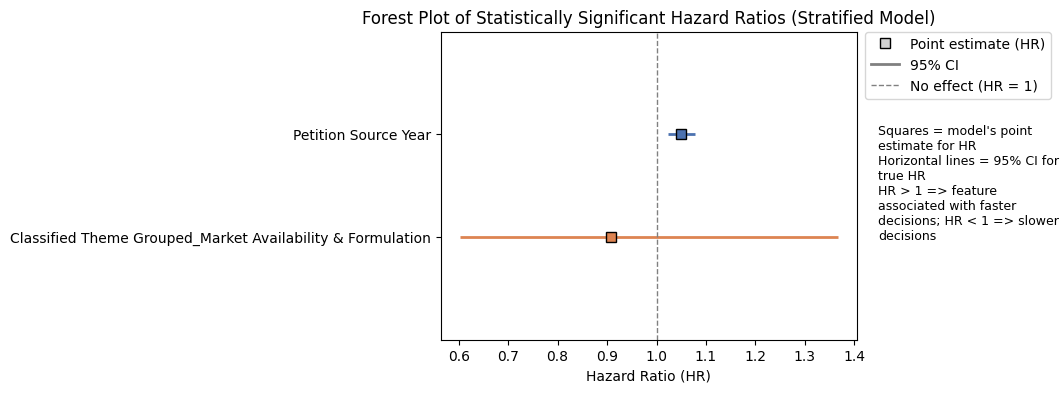

In [21]:
# prepare summary values
summary = cph_stratified.summary.copy()
#features = summary.index.tolist()

# lifelines stores coef and coef confidence bounds; exponentiate to get HR and HR CI
coef = summary["coef"].values
coef_lo = summary["coef lower 95%"].values
coef_hi = summary["coef upper 95%"].values

hr = np.exp(coef)
hr_lo = np.exp(coef_lo)
hr_hi = np.exp(coef_hi)

# colors
colors = sns.color_palette("deep", n_colors=len(significant_non_failing))

# plot
fig, ax = plt.subplots(figsize=(7, max(4, 0.4 * len(significant_non_failing))))
y = np.arange(len(significant_non_failing))

for i, feat in enumerate(significant_non_failing):
    # horizontal CI line
    ax.hlines(y=i, xmin=hr_lo[i], xmax=hr_hi[i], color=colors[i], linewidth=2)
    # central square marker
    ax.plot(hr[i], i, marker="s", color=colors[i], markersize=7, markeredgecolor="k", zorder=3)

# vertical "no effect" line at HR = 1
ax.axvline(1.0, color="grey", linestyle="--", linewidth=1)

# aesthetics
ax.set_yticks(y)
ax.set_yticklabels(significant_non_failing)
ax.set_xlabel("Hazard Ratio (HR)")
ax.set_ylim(-1, len(significant_non_failing))
ax.invert_yaxis()  # optional: match lifelines order
#ax.set_xscale("log")  # optional: log scale often clearer for HRs
plt.title("Forest Plot of Statistically Significant Hazard Ratios (Stratified Model)")

# add legend
from matplotlib.lines import Line2D

# create legend handles (generic, not per-feature)
legend_handles = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgray', markeredgecolor='k', markersize=7, label="Point estimate (HR)"),
    Line2D([0], [0], color='gray', lw=2, label="95% CI"),
    Line2D([0], [0], color='gray', lw=1, linestyle='--', label="No effect (HR = 1)")
]

# make room on the right for legend / caption
fig.subplots_adjust(right=0.72)

# place legend to the right
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# caption / explanatory key (adjust position if it overlaps)
caption = ("Squares = model's point estimate for HR \n"
           "Horizontal lines = 95% CI for true HR\n"
           "HR > 1 => feature associated with faster decisions; HR < 1 => slower decisions")
fig.text(0.75, 0.5, caption, fontsize=9, va='center', ha='left', wrap=True)

plt.show() 



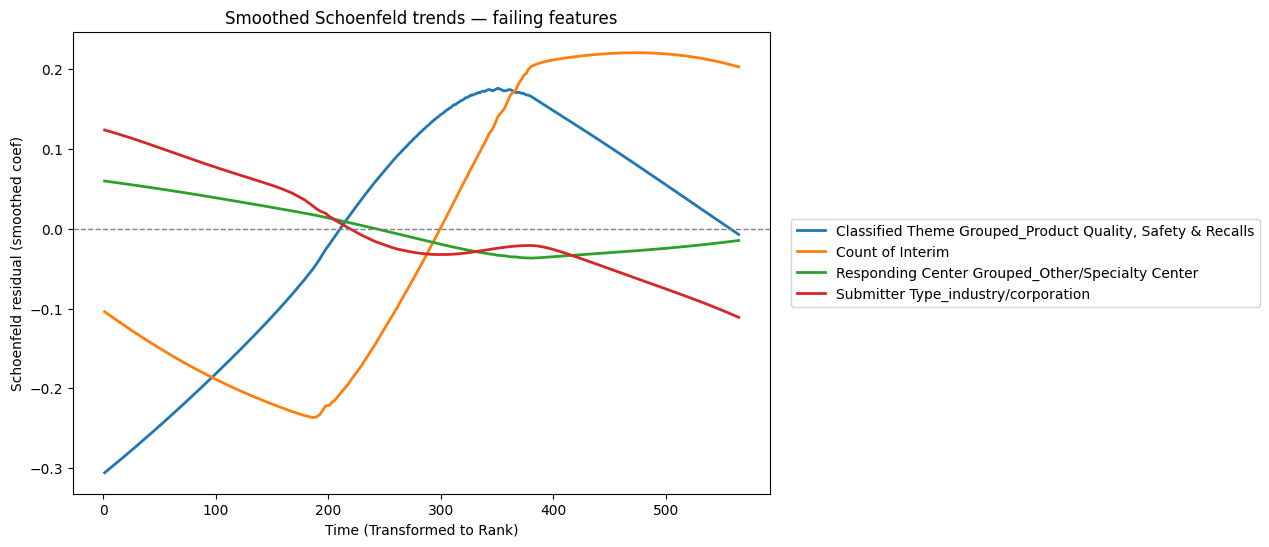

In [30]:
# Extract and plot smoothed Schoenfeld lines for failing features
from collections import OrderedDict

# try LOWESS, fallback to gaussian smoothing
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    _use_lowess = True
except Exception:
    import subprocess, sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels", "scipy"])
        from statsmodels.nonparametric.smoothers_lowess import lowess
        _use_lowess = True
    except Exception:
        # final fallback: use scipy gaussian filter
        from scipy.ndimage import gaussian_filter1d
        _use_lowess = False

# compute schoenfeld residuals (rows correspond to subjects where event occurred)
sres = cph.compute_residuals(data_encoded, kind="schoenfeld")
# times for those rows (duration at event)
times = data_encoded.loc[sres.index, "Response Time (Days)"]

# choose features to plot: use 'failing' from earlier PH test
features_to_plot = [f for f in fail_ph_stat_signif if f in sres.columns]
curves = OrderedDict()

for feat in features_to_plot:
    resid = sres[feat]
    mask = resid.notna()
    # use same time transform check_assumptions uses (e.g. 'rank' or 'log' or identity)
    time_transform = 'rank'   # match what you passed to proportional_hazard_test / check_assumptions
    if time_transform == 'rank':
        from scipy.stats import rankdata
        x = rankdata(times[mask])           # ranks of event times
    elif time_transform == 'log':
        x = np.log(times[mask].values)
    else:
        x = times[mask].values

    y = resid[mask].values
    if len(x) < 5:
        continue
    # sort by transformed time
    order = np.argsort(x)
    x_s = x[order]
    y_s = y[order]

    if _use_lowess:
        # use same LOWESS smoothing parameter lifelines uses (typical choice ~0.66)
        frac = 0.66
        sm = lowess(y_s, x_s, frac=frac, return_sorted=True)
        x_grid, y_grid = sm[:, 0], sm[:, 1]
        # center the smoothed curve so its mean = 0 (lifelines centers plots)
        y_grid = y_grid - np.nanmean(y_grid)
    else:
        # gaussian fallback: smooth the y after sorting
        sigma = max(1, int(len(y_s) * 0.02))
        y_grid = gaussian_filter1d(y_s, sigma=sigma)
        x_grid = x_s
        y_grid = y_grid - np.nanmean(y_grid)

    curves[feat] = (x_grid, y_grid)

# combined plot
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
for feat, (xg, yg) in curves.items():
    plt.plot(xg, yg, lw=2, label=feat)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Time (Transformed to Rank)")
plt.ylabel("Schoenfeld residual (smoothed coef)")
plt.title("Smoothed Schoenfeld trends — failing features")
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.show()


#### (COPIED REPORT FOR EASIER REFERENCING)
## For Features that Failed PH Test & Were Statistically Signif:
## Analyze True Relationship w/ Resp Time Using Schoenfeld Plots (USE ON REPORT)
**1. Count of Interim**
* main model: HR = 0.731227 (< 1) -> associated w/ slower response times & p-value > 0.05, this result IS significant
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: receiving an interim is assoicated with a slower response time
        * but then the line starts to increase, meaning receiving an interim is associated with a faster response time
        * near the very end: line remains constant where coef is around 1.5 -> $\text{HR} \approx e^{1.5} \approx 4.5$
* *means at that specific late time point, having that feature makes a final decision 4.5 times faster than the baseline, holding other features constant*

**2. Submitter Type_industry/corporation**
* main model: HR = 1.551604 (> 1)
    * compared to the baseline group ("academic/adv bc it's first alphabetically and used drop_first=True), industry/corp petitioners have a hazard rate about 1.55 times higher, meaning they tend to get final decisions significantly faster than academic/adv
    * i.e: academic/adv petitioners get their decisions significantly slower than indust/corp petitioners
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: there is a decrease in HR, then staying constant around coef = -1.25 -> meaning industry/corporation petitioners are actually associated with a slower response time compared to academic/adv 
        * i.e: academic/adv petitioners get their decisions faster than indust/corp petitioners
* true long-term Hazard Ratio is $\text{HR} \approx e^{-1.25} \approx 0.29$
* *means that after initial events are cleared, indus/corp petitioners are actually associated with a slower response time -> 1/0.29 = 3.44 times slower than the aca/adv baseline group to get decision* (initial average HR = 1.55 was a severely inaccurate)

**3. Responding Center Grouped_Other/Specialty Center**
* main model: HR = 1.596599 (> 1)
    * compared to the baseline group (CDER resp. center), petitions that get other/specialty center appear to get decisions 1.6 times faster than CDER
    * this category includes centers such as ['CBER', 'CFSAN', 'CVM', 'DMS', 'offices', 'other', 'CTP']
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: there is a steep decline in HR, then staying constant around coef = -1 -> meaning petitions that get "other/specialty" center is actually associated with a slower response time compared to CDER 
* true long-term Hazard Ratio is $\text{HR} \approx e^{-1} \approx 0.37$
* *means that petitions reviewed by the "other/specialty" are associated with a slower response time -> 1/0.37 = 2.7 slower than CDER baseline*

**4. Classified Theme Grouped_Product Quality, Safety & Recalls**
* main model: HR = 1.850878 (> 1) -> compared to the baseline group ("Unassigned" theme aka the average unclassifiable/noise category), petitions that get classified as "Product Quality, Safety & Recalls" appear to get decisions about 2 times faster than the average unclassifiable/noise category
* HOWEVER (according to check_assumptions) conclusion above is misleading bc it represents a single "average" effect that isn't consistent overtime (effect changes overtime) 
    * its plot: 
        * as time goes on: there is a slight increase in HR, staying constant around coef = 1 -> meaning petitions classified as Grouped_Product Quality, Safety & Recalls is associated with a faster response time
* true long-term Hazard Ratio is $\text{HR} \approx e^{1} \approx 2.72$
* means that *petitions classified as "Product Quality, Safety & Recalls" are associated with a faster response time, having $2.72$ times the hazard of the "Unassigned" baseline*; long-term magnitude of the effect is significantly greater than the initial average HR = 1.85 
